In [1]:
from typing import Union
import pdb
import diffrax
import equinox as eqx  # https://github.com/patrick-kidger/equinox
import jax
import jax.nn as jnn
import jax.numpy as jnp
import jax.random as jr
import jax.tree_util as jtu
import matplotlib.pyplot as plt
import optax  # https://github.com/deepmind/optax
import numpy as np
import control
import pdb
import jax
from jax import lax
import lineax
from helpers_impl import generate_system,  NeuralODEPlant, get_gpu_memory
from tqdm import tqdm
import gc
from IPython.display import clear_output
from jax.flatten_util import ravel_pytree
from diffrax import diffeqsolve, Tsit5, ODETerm, ReversibleHeun, Heun
jax.config.update("jax_enable_x64", False)

In [3]:
data_size=4
A,B=generate_system(data_size)

In [9]:

#initialize the dynamical system
#A=np.array([[1,0],[1,0]])
#B=np.array([[1],[0]])
x00=np.array([1,0.5])
%store  A
%store   B
%store  x00
print(A)
print(B)
print(x00)
batch_size=1  

t_size=32
t0 = 0
t1 = 1
ts = jnp.linspace(t0, t1, t_size)
tss = jnp.expand_dims(ts, axis=0)
tsss = jnp.repeat(tss, repeats=batch_size, axis=0)
#initialize the ODE
seed=5679

hidden_size=data_size
noise_size=hidden_size+1
width_size=10
depth=5

key = jr.PRNGKey(seed)

generator = NeuralODEPlant(
    data_size,
    hidden_size,
    width_size,
    depth,
    A,
    B,
    key=key,
)


#learning rate
learning_rate=0.000122/4

#adam optimizer
b1=0.9
b2=0.999
eps=1e-08
optim = optax.adam(learning_rate, b1=b1, b2=b2, eps=0, eps_root=eps)

opt_state = optim.init(eqx.filter(generator, eqx.is_inexact_array))
R=0.0


#initial conditions 
y00=jnp.append(x00, jnp.zeros((1,1)))
y0 = jnp.expand_dims(y00, axis=0)

#common denominator term
@jax.jit
def smoothed_inverse_grad(grad, eps=1e-05):
    return 1.0 / jnp.sqrt(grad + eps)

#for cost and its gradient evaluation
@eqx.filter_value_and_grad  
def loss(model):
   
    pred_y = jax.vmap(model)(tsss,  y0)
    
    los_energy = jnp.mean(jnp.sum(pred_y[:,-1,0:hidden_size]**2,axis=1))

    return los_energy

#for energy and its gradient evaluation
@eqx.filter_value_and_grad  
def loss_kin(model):
   
    pred_y = jax.vmap(model)(tsss,  y0)
    
    kin_energy=  jnp.mean(pred_y[:,-1,-1])

    return kin_energy

#for Hessian evaluation
@eqx.filter_jit
def l1(flat_params, static, unravel_fn):

    unflat_params = unravel_fn(flat_params)
    modelx = eqx.combine(static, unflat_params)

    vf =  diffrax.ODETerm(modelx.vf)

    solver = Heun(scan_kind="bounded")
    t0 = ts[0]
    t1 = ts[-1]
   
    dt=(t1-t0)/ts.shape[0]

    pred_y = diffeqsolve(vf, solver, t0=t0, t1=t1, dt0=dt, y0=y00, args=None)
    
    los_energy = jnp.mean(jnp.sum(pred_y.ys[-1,0:hidden_size]**2,axis=0))
    score= los_energy

    return score

#for evaluation of directional derivatives of control energy
@jax.jit
def rms_full_grad(flat_grads, flat_grads1, hessian,  params, eps, ema_grad, ema_sqr_grad, counter):
    #common denominator term
    ema_sqr_grad = ema_sqr_grad /(1-b2**(counter+1))
    ema_grad = ema_grad /(1-b1**(counter+1))
    denom= smoothed_inverse_grad((ema_sqr_grad), eps)
    dem2 = smoothed_inverse_grad((jnp.square(flat_grads)), eps)
    

    PP_ema= ema_grad * (hessian @ (ema_grad* denom) )

    P_multiplier=  learning_rate* denom * ((1+b1)/(1-b1)  +((1+b2)/(1-b2))* ( eps*denom**2 -1 ))/2 


    kin_decline_from_loss = -jnp.dot(flat_grads1, (ema_grad* denom)) 
    kin_decline_from_P_term = - jnp.dot(flat_grads1, PP_ema * P_multiplier ) 
 

    jax.debug.print("directional derivative along unmodified loss = {}", kin_decline_from_loss)
    jax.debug.print("directional derivative along bias term = {}",  kin_decline_from_P_term)
 
    return kin_decline_from_loss, kin_decline_from_P_term
    
@eqx.filter_jit
def make_step(model, batch_size, tsss, key, opt_state, y0,   counter, optim):

    key = jr.split(key, batch_size)
    
    #evaluate loss, energy and gradients
    value, grads = loss(model)
    value1, grads1 = loss_kin(model)
    #hessian evaluation
    arr, static = eqx.partition(model, eqx.is_inexact_array)
    params, unravel_fn = ravel_pytree(arr)
    hessian=jax.hessian(l1)(params, static, unravel_fn)
 
    #flattening the gradients
    flat_grads, _ = ravel_pytree(eqx.filter(grads, eqx.is_inexact_array))
    flat_grads1, _ = ravel_pytree(eqx.filter(grads1, eqx.is_inexact_array))

    #evaluation of ema gradients
    ema_grad = b1*ema_grad + (1-b1) * flat_grads
    ema_sqr_grad = b2*ema_sqr_grad + (1-b2) * jnp.square(flat_grads)

    cos_theta_grad_loss, cos_theta_grad_kin=rms_full_grad(flat_grads, flat_grads1, hessian, params, eps, ema_grad, ema_sqr_grad, counter)

    #update the control network
    updates, opt_state = optim.update(grads, opt_state)
    model = eqx.apply_updates(model, updates)

    counter+=1
    return model, opt_state, grads, value, value1, cos_theta_grad_kin, cos_theta_grad_loss, jnp.linalg.norm(params), ema_grad, ema_sqr_grad, counter

#compute the first values of cost and energy for ema 
tot_iter=100000
losses, grads = loss(generator)
kin, grads1 = loss_kin(generator)
arr, static = eqx.partition(generator, eqx.is_inexact_array)
params, unravel_fn = ravel_pytree(arr)
flat_grads, _ = ravel_pytree(eqx.filter(grads, eqx.is_inexact_array))
ema_grad =  flat_grads
ema_sqr_grad = jnp.square(flat_grads)

Stored 'A' (ndarray)
Stored 'B' (ndarray)
Stored 'x00' (ndarray)
[[ 0.00297536 -0.49866544  0.38726729  0.18560523]
 [-0.34248048 -0.05707196  0.25883402 -0.62387013]
 [ 0.20296438  0.85258791  0.87227747 -0.43771227]
 [-1.00686367 -0.15780359  0.45244791 -0.42324521]]
[[-0.813595   -0.35522426 -0.06564255 -0.36770342]
 [-0.10622117 -0.42615195 -0.3459727   0.14684763]
 [ 0.57933916 -0.43723429 -0.27917332  0.36156879]
 [-0.58425566  0.08898704  0.24189907 -0.0881269 ]]
[1.  0.5 0.  0. ]


In [ ]:
y00

In [13]:
#save costs and energy
saved_loss=[]
saved_kin=[]
#save directional derivatives
saved_product1=[]
saved_product2=[]

ini_key=jr.PRNGKey(seed)
key= jr.split(key, 1)[0]
alpha=0.9

counter=jnp.int32(0)
tsss = jnp.repeat(tss, repeats=batch_size, axis=0)

score=10000000
epochs=[]
ema_loss=0
for k in tqdm(range(0,tot_iter)):
   
    key= jr.split(key, 1)[0]
    #run optimization steps, evaluate the cost and energy, directional derivatives
    generator, opt_state, grads, losses, kin, cos_theta_imp, cos_theta_loss, param_norm, ema_grad, ema_sqr_grad, counter= make_step(generator, batch_size, tsss, key, opt_state, y0,  ema_grad, ema_sqr_grad,counter)
    
    if k==0:
        ema_loss=losses
    else:
        ema_loss=ema_loss*alpha+losses*(1-alpha)
    
    if ema_loss<score:
        score=ema_loss

    print("ema loss")
    print(ema_loss)
    print("kin")
    print(kin)
    saved_loss.append(jax.device_get(losses))
    saved_kin.append(jax.device_get(kin))
    saved_product1.append(jax.device_get(cos_theta_imp))
    saved_product2.append(jax.device_get(cos_theta_loss))

    if k%500==0:
        gc.collect()
        clear_output(wait=True)
        
    if jnp.linalg.norm(ema_loss)<1e-06:
        break
    del grads, losses, kin



  0%|          | 0/5 [00:00<?, ?it/s]


NameError: name 'scale_kin' is not defined

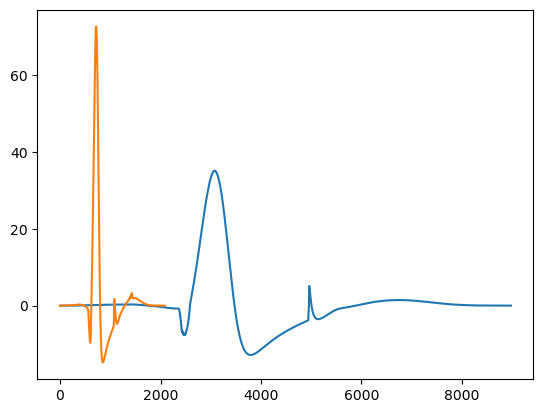

In [55]:
plt.plot(saved_product1)
plt.plot(np.array(saved_product1_13)/4)
#plt.plot(saved_product2)

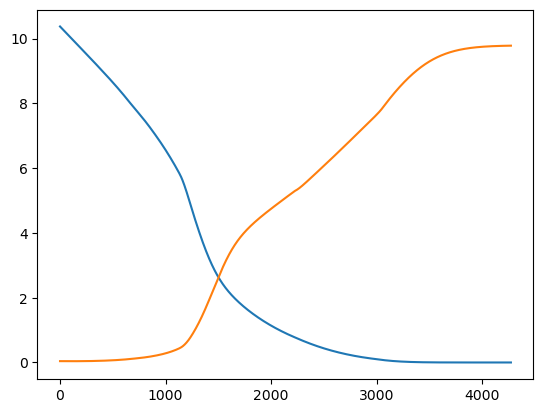

In [37]:
plt.plot(saved_loss)
plt.plot(saved_kin)

In [ ]:
saved_loss_13=saved_loss
saved_loss_13=saved_kin
saved_product1_13=saved_product1
saved_product2_13=saved_product2

In [ ]:
saved_loss_14=saved_loss
saved_loss_14=saved_kin
saved_product1_14=saved_product1
saved_product2_14=saved_product2

In [61]:
saved_kin[-1]

array(9.117623, dtype=float32)

In [65]:
saved_loss_13[-1]

array(9.968543, dtype=float32)

In [63]:
saved_loss_14[-1]

array(9.783958, dtype=float32)

In [47]:
def forward_moving_average(arr, window_size):
    """
    Smooths a 1D NumPy array using a forward-looking moving average.
    
    Args:
        arr: Input 1D NumPy array
        window_size: Size of the forward-looking window
    
    Returns:
        Smoothed NumPy array of the same length
    """
    n = len(arr)
    smoothed = np.zeros(n)
    
    for i in range(n):
        # Take the mean of the current and future elements within the window
        end_idx = min(i + window_size, n)
        smoothed[i] = np.mean(arr[i:end_idx])
    
    return smoothed

# Example usage
arr = np.array([1.0, 2.0, 3.0, 4.0, 5.0, 6.0])
window_size = 1500
smoothed_arr = forward_moving_average(np.stack(saved_product1), window_size)
print(smoothed_arr)

[-7.33367597e-06 -1.39510630e-05 -1.99794777e-05 ...  8.88864994e-02
  6.82752848e-01  1.72867680e+00]


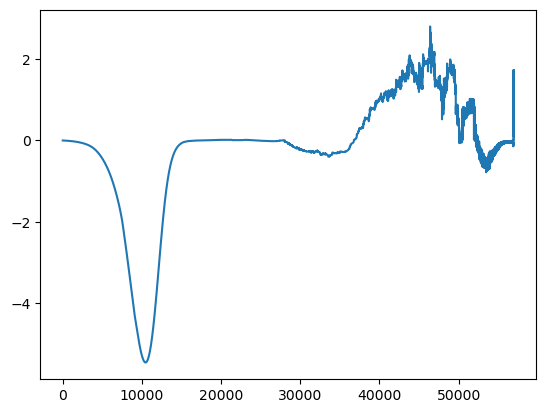

In [49]:
plt.plot(smoothed_arr)

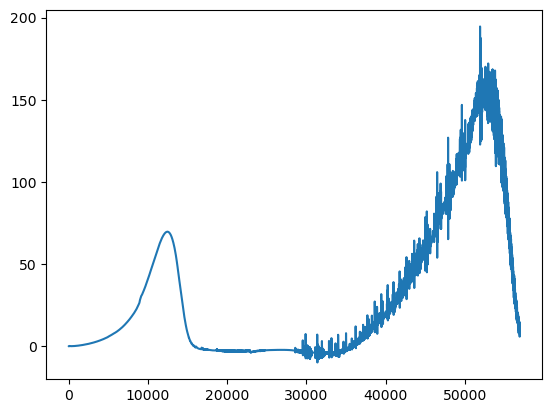

In [51]:
plt.plot(saved_product2)